In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import richardsplot as rplot # for nicer plots

We import the downloading utilities that allow us to construct URLs for various data products as well as a function that manages the downloading of multiple objects quickly.

In [3]:
from utilities.downloads import urls
from utilities.downloads.downloader import fits_downloader

We select a sample of AGN by EPIC ID.  The url generators require the campaign in which the object is observed to generate the correct URL.

In [6]:
agn_epics = [220282234, 220268684, 220284690]
campaign = 8

We then get the url for each object in our sample.  In this example, we'll get the url for the EVEREST processings.

In [9]:
agn_urls = [urls.everest(epicid, campaign) for epicid in agn_epics]
print agn_urls

['https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/82234/hlsp_everest_k2_llc_220282234-c08_kepler_v2.0_lc.fits', 'https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/68684/hlsp_everest_k2_llc_220268684-c08_kepler_v2.0_lc.fits', 'https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/84690/hlsp_everest_k2_llc_220284690-c08_kepler_v2.0_lc.fits']


Now we'll use the downloader to retrieve the fits files from the MAST database.  The fits_downloader function is a generator object, so we must iterate over it to retrieve the fits files.  In our case though, we'll just convert it to a list.

By default, the fits_downloader function returns the fits hdus in the order that the urls are given.  By setting the keyword argument to ordered=False, downlaoding can be significantly sped up, at the cost of the order of the returned hdus being random.

In [10]:
agn_files = list(fits_downloader(agn_urls, ordered=True)) 
# this way it becomes indexable
print agn_files

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fac7676c790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac767a2310>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac767a2850>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fac767b7690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac767bf650>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fac767cb490>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fac7676c0d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac746f8390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac746f88d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fac74708710>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac74712710>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fac7471d550>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fac7685da50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac746c1790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac746c1cd0>, <astropy.io.fits.hd

Now that we have our fits files, we'll need to understand their structure.  More information about the structure of the individual science product can be found in the K2 Data Archive Manual: https://archive.stsci.edu/kepler/manuals/archive_manual.pdf

For now, we'll just inspect the first file using the hdu.info() method.

In [11]:
agn220282234 = agn_files[0]
print agn220282234.info()

Filename: <type '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  ARRAYS        1 BinTableHDU    310   3853R x 13C   [D, D, D, D, J, D, D, D, D, D, D, D, D]   
  2  PIXELS        1 BinTableHDU     19   3853R x 2C   [41D, 462D]   
  3  APERTURE MASK    1 ImageHDU        54   (9, 8)   int64   
  4  POSTAGE STAMPS    1 BinTableHDU     61   8R x 3C   [9D, 9D, 9D]   
  5  HI RES IMAGE    1 ImageHDU        54   (90, 80)   float64   
None


First, let's verify that we are looking at the correct object.  We assume the EPIC ID of this agn is 220282234, but we can look at the header of the PRIMARY hdu to be certain.

In [15]:
print agn220282234['PRIMARY'].header['KEPLERID']

220282234


So we know this is the right object and I didn't screw up my code.  Now, the light curve data is going to be in the hdu named 'ARRAYS', so we'll inspect the data fields available there. 

In [16]:
print agn220282234['ARRAYS'].data.names

['CADN', 'FLUX', 'FRAW', 'FRAW_ERR', 'QUALITY', 'TIME', 'FCOR', 'CBV01', 'CBV02', 'CBV03', 'CBV04', 'CBV05', 'CBV06']


So this is pretty straigt forward.  If we want the corrected flux of this AGN, we'll grab the FCOR column, and we'll use the TIME column for the temporal dimension.  Information about the other columns can be found in the Kepler Archive Manual

In [35]:
flux_cor = agn220282234['ARRAYS'].data['FCOR']
t = agn220282234['ARRAYS'].data['TIME']

And now we'll plot our EVEREST corrected light curve with matplotlib

(2559.0687976760892, 2637.7719715894418)

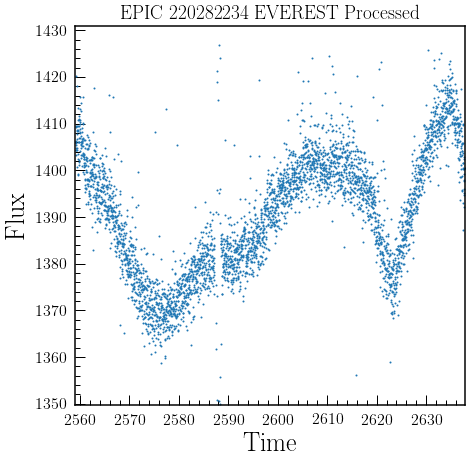

In [40]:
plt.plot(t, flux_cor, marker='.', ls=' ', ms=2)

# some plot formatting
plt.xlabel('Time', fontsize=26)
plt.ylabel('Flux', fontsize=26)
plt.title('EPIC 220282234 EVEREST Processed')

# applying more intelligent plot limits at 2 std
n_std = 2*np.array([-1,1])
# do a little sigma clipping to remove outliers
data_limits = np.mean(flux_cor)+np.std(flux_cor)*n_std
mask = (flux_cor > data_limits[0]) & (flux_cor < data_limits[1])
plot_limits = np.mean(flux_cor[mask])+np.std(flux_cor[mask])*n_std
               
plt.ylim(plot_limits)
plt.xlim(t[[0,-1]])

We can do this now for all objects by iterating over the list of fits files.

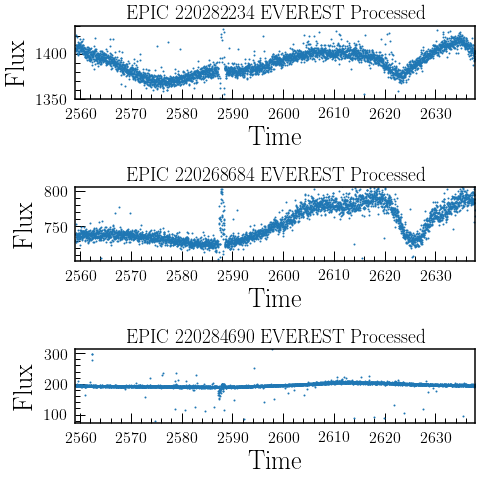

In [44]:
fig, ax = plt.subplots(3,1)

for ax, agn in zip(ax, agn_files):
    # retrieve our data for the object
    flux_cor = agn['ARRAYS'].data['FCOR']
    t = agn['ARRAYS'].data['TIME']
    epic = agn['PRIMARY'].header['KEPLERID']
    
    # make a plot of the light curve
    ax.plot(t, flux_cor, marker='.', ls=' ', ms=2)

    # some plot formatting
    ax.set_xlabel('Time', fontsize=26)
    ax.set_ylabel('Flux', fontsize=26)
    ax.set_title('EPIC {0} EVEREST Processed'.format(epic))

    # applying more intelligent plot limits at 2 std
    n_std = 2*np.array([-1,1])
    # do a little sigma clipping to remove outliers
    data_limits = np.mean(flux_cor)+np.std(flux_cor)*n_std
    mask = (flux_cor > data_limits[0]) & (flux_cor < data_limits[1])
    plot_limits = np.mean(flux_cor[mask])+np.std(flux_cor[mask])*n_std

    ax.set_ylim(plot_limits)
    ax.set_xlim(t[[0,-1]])
    
fig.tight_layout()